---
title: Calculating 'Team-Attention' within Company using Viewer Statistics of Intranet Posts
description: 게시글의 조회수 분석을 통해 사내 부서 간의 '관심도'(또는, 업무 관련성)를 추정해보는 실험입니다.
author: johnjoon2004
date: 2025-06-08
categories: [EXPERIMENTAL, JUST-FOR-FUN]
image: ../images/post_250608_team_distance/heatmap.png
draft: false
---

:::{.callout-warning}
## THIS IS IMPORTANT
데이터 크롤링에 앞서, 어떠한 데이터를 수집하더라도 실행 전 <u>**반드시 해당 사이트 및 조직의 크롤링 정책을 확인**</u>하고, 수집 동작이 운영에 지장이 없도록 각별히 주의해야 합니다. 또한 수집 시 <u>**개인정보를 회피**</u>하여, 이것이 아예 크롤링 프로세스에 인입되지 않도록 구현하는 것이 좋습니다.

본 실험에 활용된 데이터는 수집 전 상급자 및 인프라 담당자의 동의를 거쳤으며, 수집된 데이터에는 민감 정보가 일체 포함되어 있지 않습니다. 해당 데이터는 회사의 정책에 따라 외부에 노출, 전송, 복사 등이 이뤄지지 않고 있으며, 실험 목적 외에는 사용되지 않습니다.

:::

## 1. 실험 설명

최근, 저의 회사에서는 사무실 확장과 함께 부서별 공간 재배치 작업이 있었습니다. 이 과정에서, 비록 각 부서간 업무 관련성을 기준으로 배치를 진행하는 노력이 있었으나, 이를 정량적으로 평가할 수 있는 기준이 부재했던 아쉬움이 있었습니다. 즉, 각 부서가 서로 얼마나 밀접하게 협업하는지, 소통이 얼마나 빈번하게 일어나는지를 구체적으로 측정할 수 있는 수단이 없었습니다. 본 실험은 이러한 배경 아래 진행되었습니다.

본 실험은 회사의 인트라넷에 공개된 게시글의 조회 통계를 통해 각 팀(부서) 간의 '관심도'를 정량적으로 추정해보는 실험입니다. 여기서 **관심도**란, 서로 다른 부서 사이의 **업무 관련도**, **협업의 강도** 등으로 해석될 수 있습니다.

대부분의 회사에는 다양한 직군과 부서들이 공존합니다. 만약 각 팀 간의 업무 관련성, 또는 협업 강도를 정량적으로 분석할 수 있는 척도가 있다면, 이를 기반으로 <u>팀 간 협업과 커뮤니케이션 상태를 점검 및 조율하고, 조직 구성을 최적화</u>하는 등, 기업 운영 시 매우 유용하게 활용될 여지가 있습니다.

- 예를 들어, 회사의 사무 공간이 부득이하게 분산되어 있다고 가정해봅시다. 회사의 사무실이 총 3개의 층으로 나뉘어 있는 상태이며, 건물의 2층, 3층, 그리고 19층에 각 팀을 배치해야 하는 상황입니다. 이 때, 각 부서 간의 협업/관련 정도을 정량적으로 측정할 수 있다면, <u>업무 관련성이 높은 팀을 가까운 공간에 배치</u>하고, 반대로 <u>업무 관련성이 낮은 팀은 서로 멀리 배치</u>하여도 무방하기에, 협업 효율을 최적화할 수 있는 공간 배치 전략을 수립할 수 있습니다.

## 2. 기본 접근법

회사 인트라넷의 전체 게시글 데이터를 실험 데이터셋으로 활용합니다.

- 회사의 모든 구성원들이 통일된 플랫폼에서 모든 문서 작업을 수행하는 상황을 가정합니다.

- 모든 게시글에 조회 기록이 자동으로 남겨지는 점을 활용합니다. 각 게시글은 **작성자**, **조회자** 및 조회자별 열람 횟수 등 정보를 포함하고 있습니다. 이를 통해 **작성자-조회수 맵핑**을 통해 부서 간 상호작용을 모델링할 수 있습니다.

일반적인 IT 기업에는 기획, 연구 개발, 운영, 인사, 영업 등 직무가 존재하며, 저희 회사 또한 이와 유사한 조직 구조를 가지고 있습니다. 때문에 회사는 다양한 유형의 업무 수행을 지원하기 위해 꽤나 많은 게시판을 인트라넷에 구축해두었고, 각 팀마다 주로 사용하는 게시판이 나뉘게 됩니다. 또한 각 게시글은 게시판 및 작성자가 속한 팀과 따라 그 내용이 상당히 다른 특성을 지니게 됩니다. 

- 따라서 <u>각 게시판의 특성에 따라 메트릭 또는 가중치를 별도로 처리</u>하는 과정이 필요할 수 있습니다.

## 3. 실험 환경 세팅

실험에 사용될 라이브러리는 (일단은) 다음과 같습니다. 이들을 `import` 해줍니다.

In [4]:
import math
import re
from collections import defaultdict
from pprint import pprint
from typing import Dict

import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

데이터를 로드해줍니다. 본 실험에서는 `csv` 형식의 원본 데이터 파일이 이미 확보되어 있는 상태를 가정합니다.

In [5]:
data = pd.read_csv("../private/post_250608_team_distance/company_posts.csv")

## 4. 데이터 분석(EDA) 및 전처리

먼저 데이터에 포함된 칼럼들을 확인해봅니다.

In [3]:
data.columns

Index(['Unnamed: 0', 'link', 'title', 'creator', 'board', 'text', 'readers'], dtype='object')

각 칼럼의 의미는 다음과 같습니다:

| 칼럼     | 설명                        | 필요 여부 |
|----------|-----------------------------|:---------:|
| Unnamed: 0     | 게시글의 인덱스                |    X     |
| link     | 게시글의 URL                |    X     |
| title    | 게시글 제목                 |    X     |
| creator  | 게시글 작성자               |    O     |
| board    | 게시글이 속한 게시판         |    O     |
| text     | 게시글 본문                 |    X     |
| readers  | 게시글 조회자 및 조회수 목록 |    O     |


불필요한 칼럼을 제거합니다.

In [6]:
cols_to_remove = ["Unnamed: 0", "link", "title", "text"]
data.drop(columns=cols_to_remove, inplace=True)

게시판(`board`) 칼럼의 경우, 조금 더 세부적으로 분류할 필요가 있습니다. 

대부분의 게시판의 경우, 게시글들이 개인 또는 특정 팀이 대부분을 기여하지만, 특정 게시판의 경우 범-부서적 차원에서, 또는 전사 공통으로 작성/유지보수되는 경우가 있기 때문입니다. 후자에 해당하는 게시글의 경우, 여러 팀이 작성에 기여했으나, <u>조회수가 투영하는 모든 '관심도'의 기여분이 특정 작성자에게 편중되는 문제</u>가 발생할 수 있습니다. 따라서 본 실험에서는 다음과 같은 주관적 기준을 제시합니다: 

- `isolation`: 개인/팀 차원에 해당한다고 판단되는 게시판의 경우 해당 그룹으로 분류하고, 모든 게시글의 조회수에 `1.0` 만큼의 가중치를 적용시킵니다.
- `association`: 다수의 부서/전사 차원에 해당한다고 판단되는 게시판의 경우 해당 그룹으로 분류하고, 모든 게시글의 조회수에 `0.5` 만큼의 가중치를 적용시킵니다.

:::{.callout-note}
## NOTE
이는 굉장히 naive하고 주관적인 방식이지만, 본 실험에서는 이 이상으로 deep dive하지 않습니다.😿

:::

위와 같은 기준에 따라 게시판 유형(`board_type`) 태그를 데이터셋에 새로운 칼럼으로 추가하고, 불필요한 게시판 항목은 제거합니다. (전체 게시판 정보를 출력할 수 없는 점 양해 바랍니다)

In [7]:
import sys
if ".." not in sys.path:
    sys.path.append("..")
from private.post_250608_team_distance.board_categories import boards_isolation, boards_association

In [6]:
sample_isolation_boards = (
    "연구노트",
    "개인게시판",
    ...
)

sample_association_boards = (
    "회의록",
    "제품매뉴얼",
    ...
)

In [8]:
data = data[data["board"].isin(boards_isolation + boards_association)].reset_index(drop=True)

In [9]:
def calculate_weight_by_board(board):
    if board in boards_isolation:
        return 1
    elif board in boards_association:
        return 0.5
    else:
        raise

data["board_weight"] = data["board"].apply(calculate_weight_by_board)

각 팀별 구성원(재직자) 목록을 로드합니다. 다음과 같은 형식의 `json` 파일로부터 목록을 불러오는 것으로 가정합니다.

In [11]:
_employees = pd.read_json("../private/post_250608_team_distance/employees.json")

In [10]:
sample_employees = [
    {
        "name": "홍길동",
        "unit": "제1기획팀"
    },
    {
        "name": "임꺽정",
        "unit": "플랫폼개발팀"
    },
    ...
]

해당 명단에 없는 작성자(퇴사자)가 작성한 게시글의 경우 제거합니다. (소속 정보를 획득할 수 없기 때문입니다)

In [12]:
data = data[data["creator"].isin(_employees["name"].tolist())].reset_index(drop=True)

구성원-소속팀 정보를 매핑하고, 게시글 데이터셋에 작성자의 소속 팀 정보를 추가합니다.

In [14]:
_unit_map = {}

def get_unit(name: str) -> str:
    if name not in _unit_map:
        _unit_map[name] = _employees[_employees["name"] == name]["unit"].values[0]
    return _unit_map[name]

data["unit"] = data["creator"].apply(get_unit)

앞서 처리한 데이터셋에는 실제 직원명 및 부서명이 포함되어 있었고, 이는 출력되면 안되는 정보들이죠.

이를 해결하기 위해, `data`에 포함된 모든 실명을 `Faker` 라이브러리를 사용해 익명화 처리합니다.

In [17]:
from faker import Faker

goat = Faker("ko_KR")

![goat](../images/post_250608_team_distance/faker.jpg)

In [18]:
_name_map = {}

def get_fake_name(real_name: str) -> str:
    if real_name not in _name_map:
        _name_map[real_name] = goat.name()
    return _name_map[real_name]

data["creator"] = data["creator"].apply(get_fake_name)

In [19]:
fake_unit_map = {}
for name, unit in _unit_map.items():
    fake_unit_map[get_fake_name(name)] = unit

마지막으로 조회자 목록(`readers`)에 대한 전처리를 진행합니다. 

기존 `readers` 칼럼에는 아래와 같은 형식으로 '작성자' + '조회수'가 기록되어 있습니다. 이를 파싱한 다음, 각 조회자의 소속팀 정보를 식별하여 ('조회자', '팀', '조회수') 형식의 triplet을 구성하여 `readers` 칼럼을 업데이트합니다.

전체 조회자 목록 예시:

- 김철수 (5)
- 나영희 (3)
- 다람쥐 (1)
- ...


In [20]:
def parse_readers(readers_text: str) -> list[Dict[str, int]]:
    pttn = re.compile(r"([가-힣A-Za-z]+)\((\d+)\)")
    readers = pttn.findall(readers_text)
    readers_parsed = []
    for name, count in readers:
        if name not in _unit_map:
            continue
        fake_name = get_fake_name(name)
        unit = _unit_map[name]
        readers_parsed.append({
            "name": fake_name,
            "unit": unit,
            "count": int(count),
        })
    return readers_parsed

data["readers"] = data["readers"].apply(parse_readers)

조회수 파싱이 완료되었으면, 이제 실명이 포함된 데이터는 삭제합니다.

In [19]:
del _employees, _unit_map, _name_map

:::{.callout-note}
앞으로 표시되는 이름은 모두 익명화 처리된 이름입니다

:::

전처리 완료된 데이터셋의 예시는 다음과 같습니다:

In [21]:
data.head()

,creator,board,readers,board_weight,unit
0,이현우,개인업무계획,"[{'name': '이현우', 'unit': '제1개발팀', 'count': 233...",1.0,제1개발팀
1,이은주,회의록,"[{'name': '권미숙', 'unit': '인공지능팀', 'count': 9},...",0.5,영업팀
2,이은주,영업,"[{'name': '권미숙', 'unit': '인공지능팀', 'count': 11}...",1.0,영업팀
3,고재현,개발노트,"[{'name': '권미숙', 'unit': '인공지능팀', 'count': 9},...",1.0,인공지능팀
4,고재현,제품매뉴얼,"[{'name': '권미숙', 'unit': '인공지능팀', 'count': 9},...",0.5,인공지능팀


조회수 데이터는 다음과 같이 파싱되어 있습니다:

In [26]:
pprint(data.iloc[0]["readers"][:5])
print("...")

[{'count': 233, 'name': '이현우', 'unit': '제1개발팀'},
 {'count': 19, 'name': '김정숙', 'unit': '영업팀'},
 {'count': 18, 'name': '이숙자', 'unit': '제1개발팀'},
 {'count': 15, 'name': '김광수', 'unit': 'CS팀'},
 {'count': 11, 'name': '권미숙', 'unit': '인공지능팀'}]
...


분석에 활용된 데이터셋의 규모는 다음과 같습니다:

In [27]:
print("데이터셋 크기: ", len(data))

데이터셋 크기:  5138


## 5. Team-Attention 계산 알고리즘

이제 본격적으로 게시글별 조회 통계를 기반으로 팀 간의 '관심도'를 계산하는 알고리즘을 구현합니다.

각 게시글의 조회자 목록(`readers`)을 순회하며, 각 팀의 총 조회수를 추산하는 방식입니다. 이 때, 다음 사항을 유의해야 합니다:

- 조회 통계에는 본인의 열람 기록 또한 포함되어 있기 때문에, 이를 제외하고 계산해야 합니다.

- 특정 게시글에 특정 인원의 조회수가 과도하게 높은 경우가 있습니다. 이는 해당 인원이 해당 게시글을 주로 유지보수하는 역할이거나, 반복적으로 팔로우업 했던것이 원인일 가능성이 높습니다. 이는 해당 팀과 게시글 간의 실제 관련성을 왜곡할 수 있으므로, **Sigmoid 함수를 적용**하여 과도하게 높은 조회수를 조정할 필요가 있습니다. (본 실험에서는 1~10 범위로 정규화합니다)

- 이러한 정규화가 반영하는 중요한 관점은, 조회수가 없는 것과, 1회 또는 2회 정도의 조회수를 보인 것은 매우 유의미한 차이라고 볼 수 있으나, 무작정 높은 조회수를 보였다고 해서 그만큼 업무 관련성/관심도가 높다고 볼 수는 없다는 것입니다. 가령, 100회 또는 그 이상의 조회수는 사실상 10회 이상의 조회수와 구분되는 만큼의 의미를 가지지 않는다고 판단합니다. 아래의 수식은 이러한 관점을 반영합니다.

$$
\text{sigmoid-scaled}(x) = 1 + 9 \times \frac{\sigma(\alpha(x - 1)) - \sigma(0)}{1 - \sigma(0)}
$$

$$
\text{where} \quad \sigma(z) = \frac{1}{1 + e^{-z}}
$$

In [28]:
def sigmoid(x, alpha=0.5):
    s0 = 1 / (1 + np.exp(-alpha * (1 - 1)))
    sX = 1 / (1 + np.exp(-alpha * (x - 1)))
    y = 1 + 9 * (sX - s0) / (1 - s0)
    return y

def sigmoid_count(readers: list[dict]):
    return [{**reader, "count": sigmoid(reader["count"])} for reader in readers]

data["readers"] = data["readers"].apply(sigmoid_count)

위를 실행하면 조회수가 다음과 같이 0 ~ 10 범위로 정규화됩니다:

In [30]:
pprint(data.iloc[0]["readers"][:5])
print("...")

[{'count': np.float64(10.0), 'name': '이현우', 'unit': '제1개발팀'},
 {'count': np.float64(9.997778897632246), 'name': '김정숙', 'unit': '영업팀'},
 {'count': np.float64(9.996338314395006), 'name': '이숙자', 'unit': '제1개발팀'},
 {'count': np.float64(9.98360107850079), 'name': '김광수', 'unit': 'CS팀'},
 {'count': np.float64(9.879528683362874), 'name': '권미숙', 'unit': '인공지능팀'}]
...


이제 팀 간 전체 '관심도'(`unit_total_attention`)를 계산합니다.

먼저 각 게시글의 작성자(`creator`)와 조회자(`reader`)의 소속 팀을 쌍(tuple)로 묶어 '관심 방향'을 벡터화 표현하고, 관심의 '강도'를 정규화가 적용된 조회수, 그리고 게시판의 가중치를 곱하는 방식으로 계산합니다.

In [31]:
unit_total_attentions = defaultdict(float)
for _, post in data.iterrows():
    unit1 = post["unit"]
    board_weight = post["board_weight"]
    for reader in post["readers"]:
        unit2 = reader["unit"]
        unit_total_attentions[(unit1, unit2)] += reader["count"] * board_weight

그런 다음, 팀별 구성원의 수를 전체 관심도(`unit_total_attention`)에 나누어 평균 관심도(`unit_avg_attention`)를 얻습니다.

In [32]:
unit_set = data["unit"].unique().tolist()

unit_avg_attentions = defaultdict(float)
for unit1 in unit_set:
    unit_members = data[data["unit"] == unit1]["creator"].unique().tolist()
    term = len(unit_members)
    for unit2 in unit_set:
        vec = (unit1, unit2)
        unit_avg_attentions[vec] = unit_total_attentions[vec] / term

드물긴 하지만, 만약 어떤 팀이 다른 특정 팀에 대한 조회수가 0일 경우(즉, 관심도가 0), 이를 명시해줍니다.

In [33]:
for unit1 in unit_set:
    for unit2 in unit_set:
        if (unit1, unit2) not in unit_avg_attentions:
            unit_avg_attentions[(unit1, unit2)] = 0.0

앞서 계산한 '관심도'는 방향성이 있습니다. 두 팀 간의 관심도를 결합하는 방식으로 두 팀 사이의 '상호 관심도'(`unit_avg_attentions_bi`)를 계산해봅시다. 계산된 '상호 관심도'는 멱등성을 지니게 됩니다.

In [34]:
unit_avg_attentions_bi = defaultdict(float)
for unit1 in unit_set:
    for unit2 in unit_set:
        vec = tuple(sorted([unit1, unit2]))
        avg_attn_score = unit_avg_attentions[vec]
        unit_avg_attentions_bi[vec] += avg_attn_score

계산된 조합이 맞는지 확인해봅니다.

In [35]:
assert len(unit_avg_attentions_bi.keys()) == math.comb(len(unit_set) + 1, 2)

에러가 발생하지 않았습니다. 모든 팀 사이의 '상호 관심도' 값이 올바르게 매핑된 것 같습니다.

# 6. 시각화 분석

이제 계산은 완료되었습니다! 이어서 결과를 시각화해봅니다.

In [36]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

font_path = "C:/Windows/Fonts/malgun.ttf"
fontprop = fm.FontProperties(fname=font_path)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

먼저 각 팀 사이의 관심도(`unit_avg_attentions`)를 히트맵으로 시각화합니다. (시각화 효과를 위해서 특정한 범위의 스케일링을 적용하였습니다)

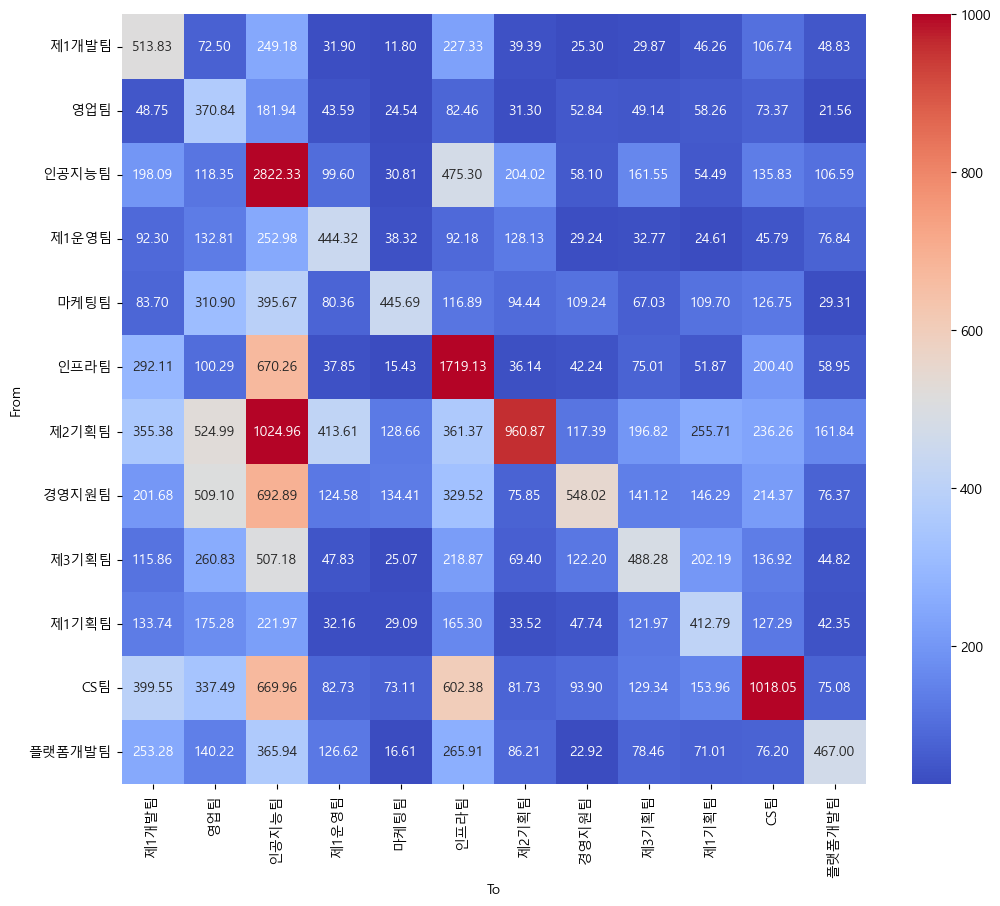

In [37]:
attn_matrix = pd.DataFrame(np.inf, index=unit_set, columns=unit_set)
for (unit1, unit2), attn_score in unit_avg_attentions.items():
    attn_matrix.loc[unit1, unit2] = attn_score

plt.figure(figsize=(12, 10))
sns.heatmap(
    attn_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    vmin=25, vmax=1000
)
plt.xlabel("To")
plt.ylabel("From")
plt.show()

:::{.callout-tip}
## Insight
- 그래프에서 여러 팀 사이의 관심도가 명확히 관찰되는 것 같습니다. 예를 들어, "제2기획팀"은 "인공지능팀"에 높은 관심도를 보이고 있었네요!😂
- 실제로도, "제2기획팀"은 사내 AI 제품군의 기획과 프로젝트 관리를 담당하는 부서로, AI 서비스 개발 및 모델 서빙을 담당하는 "인공지능팀"과 평소에 매우 긴밀한 협업이 지속되어 왔습니다.
- "제2기획팀", "경영지원팀"과 "CS팀"이 타 팀들에게 두루두루 관심을 보이는 흥미로운 경향이 발견됩니다.
- 이에 비해 상대적으로 "시크한" 스타일의 팀도 있는 것 같습니다...
- 그 중, "인공지능팀"은 팀원 서로의 '관심도'가 외부 팀에 대한 관심도에 비해 매우 높은 경향이 있습니다. 구성원 중 누군가 게시글을 올리면 "인공지능팀"은 결코 놓치는 법이 없는 것 같습니다.😅

:::

그래프 형태로도 부서 간 관심도를 시각화해볼 수 있습니다. 이 때 각 노드(node)의 크기는 게시글의 수량을, 각 엣지(edge)의 굵기는 관심도의 크기를 나타냅니다.

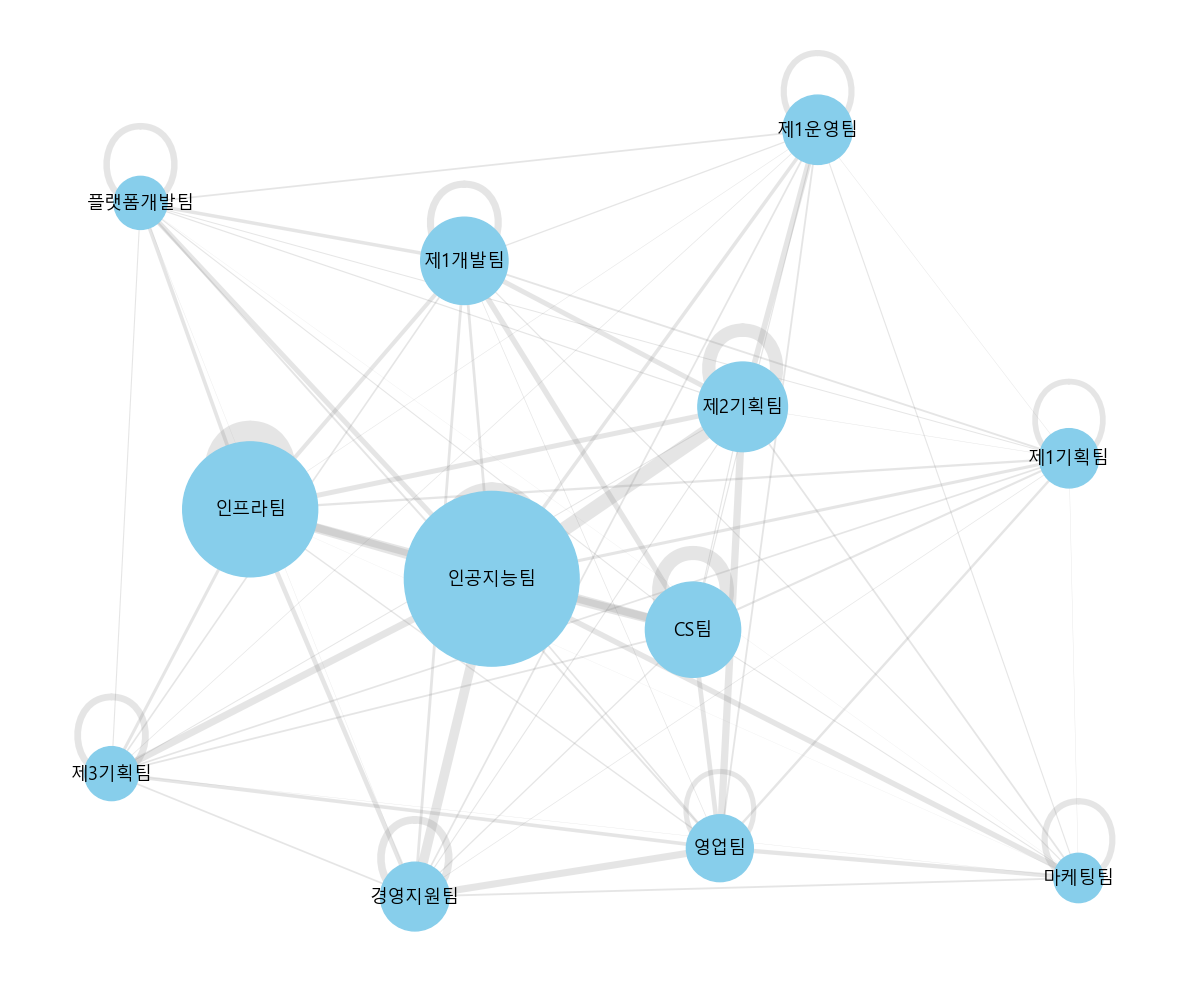

In [40]:
G = nx.Graph()
G.add_nodes_from(unit_set)
for (unit1, unit2), attn_score in unit_avg_attentions.items():
    G.add_edge(unit1, unit2, weight=attn_score)

unit_counts = data["unit"].value_counts().to_dict()
node_sizes = [10 * unit_counts.get(node, 1) for node in G.nodes]

pos = nx.spring_layout(G, seed=42, k=1.2, scale=3.0)
edges = G.edges(data=True)
edge_widths = [data['weight']/100 for _, _, data in edges]

plt.figure(figsize=(12, 10))
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color="skyblue")
nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color="gray", alpha=0.2)

for node, (x, y) in pos.items():
    plt.text(
        x, y, s=node,
        fontproperties=fontprop,
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=13,
        color="black"
    )

plt.axis("off")
plt.tight_layout()
plt.show()

Python 시각화에 흔히 쓰이는 Heatmap과 networkx 말고도, 다른 시각화 방식도 있습니다. 그 중, `holoviews` 라이브러리는 인터랙티브한 시각화를 지원합니다.

In [60]:
import holoviews as hv
from holoviews import opts

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
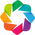

:Chord   [source,target]   (value)

In [61]:
hv.extension('bokeh')

links = pd.DataFrame([
    {"source": source, "target": target, "value": value} for (source, target), value in unit_avg_attentions_bi.items()
])

chord = hv.Chord(links)
chord.opts(
    opts.Chord(
        labels='index',
        cmap='Category20',
        edge_cmap='viridis',
        edge_color='weight',
        node_color='index',
    )
)

# 7. 결론

회사 인트라넷 게시글의 조회수 분석을 기반으로 각 부서 간 관심도를 계산하는 실험을 진행해보았습니다. 실험 결과, 실제로 협업이 비교적 긴밀한 부서 사이에서 높은 관심도(즉, 게시글의 높은 조회 빈도)가 관찰되었습니다.

해당 실험을 통해 부서 간 협업 상태를 간접적으로 평가할 수 있는 척도를 손쉽게 도출할 수 있다는 인사이트를 얻을 수 있습니다.